# Reading netCDF data
- requires [numpy](http://numpy.scipy.org) and netCDF/HDF5 C libraries.
- Github site: https://github.com/Unidata/netcdf4-python
- Online docs: http://unidata.github.io/netcdf4-python/
- Based on Konrad Hinsen's old [Scientific.IO.NetCDF](http://dirac.cnrs-orleans.fr/plone/software/scientificpython/) API, with lots of added netcdf version 4 features.
- Developed by Jeff Whitaker at NOAA, with many contributions from users.

## Interactively exploring a netCDF File

Let's explore a netCDF file from the *Atlantic Real-Time Ocean Forecast System*

first, import netcdf4-python and numpy

In [1]:
import netCDF4
import numpy as np

## Create a netCDF4.Dataset object
- **`f`** is a `Dataset` object, representing an open netCDF file.
- printing the object gives you summary information, similar to *`ncdump -h`*.

In [2]:
f = netCDF4.Dataset('data/rtofs_glo_3dz_f006_6hrly_reg3.nc')
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: HYCOM ATLb2.00
    institution: National Centers for Environmental Prediction
    source: HYCOM archive file
    experiment: 90.9
    history: archv2ncdf3z
    dimensions(sizes): MT(1), Y(850), X(712), Depth(10)
    variables(dimensions): float64 MT(MT), float64 Date(MT), float32 Depth(Depth), int32 Y(Y), int32 X(X), float32 Latitude(Y, X), float32 Longitude(Y, X), float32 u(MT, Depth, Y, X), float32 v(MT, Depth, Y, X), float32 temperature(MT, Depth, Y, X), float32 salinity(MT, Depth, Y, X)
    groups: 


## Access a netCDF variable
- variable objects stored by name in **`variables`** dict.
- print the variable yields summary info (including all the attributes).
- no actual data read yet (just have a reference to the variable object with metadata).

In [3]:
print(f.variables.keys()) # get all variable names
temp = f.variables['temperature']  # temperature variable
print(temp) 

dict_keys(['MT', 'Date', 'Depth', 'Y', 'X', 'Latitude', 'Longitude', 'u', 'v', 'temperature', 'salinity'])
<class 'netCDF4._netCDF4.Variable'>
float32 temperature(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: sea_water_potential_temperature
    units: degC
    _FillValue: 1.2676506e+30
    valid_range: [-5.078603  11.1498995]
    long_name:   temp [90.9H]
unlimited dimensions: MT
current shape = (1, 10, 850, 712)
filling on


## List the Dimensions

- All variables in a netCDF file have an associated shape, specified by a list of dimensions.
- Let's list all the dimensions in this netCDF file.
- Note that the **`MT`** dimension is special (*`unlimited`*), which means it can be appended to.

In [4]:
for d in f.dimensions.items():
    print(d)

('MT', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'MT', size = 1)
('Y', <class 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 850)
('X', <class 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 712)
('Depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'Depth', size = 10)


Each variable has a **`dimensions`** and a **`shape`** attribute.

In [5]:
temp.dimensions

('MT', 'Depth', 'Y', 'X')

In [6]:
temp.shape

(1, 10, 850, 712)

### Each dimension typically has a variable associated with it (called a *coordinate* variable).
- *Coordinate variables* are 1D variables that have the same name as dimensions.
- Coordinate variables and *auxiliary coordinate variables* (named by the *coordinates* attribute) locate values in time and space.

In [7]:
mt = f.variables['MT']
depth = f.variables['Depth']
x,y = f.variables['X'], f.variables['Y']
print(mt)
print(x)                 

<class 'netCDF4._netCDF4.Variable'>
float64 MT(MT)
    long_name: time
    units: days since 1900-12-31 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: MT
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32 X(X)
    point_spacing: even
    axis: X
unlimited dimensions: 
current shape = (712,)
filling on, default _FillValue of -2147483647 used


## Accessing data from a netCDF variable object

- netCDF variables objects behave much like numpy arrays.
- slicing a netCDF variable object returns a numpy array with the data.
- Boolean array and integer sequence indexing behaves differently for netCDF variables than for numpy arrays. Only 1-d boolean arrays and integer sequences are allowed, and these indices work independently along each dimension (similar to the way vector subscripts work in fortran).

In [8]:
time = mt[:]  # Reads the netCDF variable MT, array of one element
print(time) 

[41023.25]


In [9]:
dpth = depth[:] # examine depth array
print(dpth) 

[   0.  100.  200.  400.  700. 1000. 2000. 3000. 4000. 5000.]


In [10]:
xx,yy = x[:],y[:]
print('shape of temp variable: %s' % repr(temp.shape))
tempslice = temp[0, dpth > 400, yy > yy.max()/2, xx > xx.max()/2]
print('shape of temp slice: %s' % repr(tempslice.shape))

shape of temp variable: (1, 10, 850, 712)
shape of temp slice: (6, 425, 356)


## What is the sea surface temperature and salinity at 50N, 140W?
### Finding the latitude and longitude indices of 50N, 140W

- The `X` and `Y` dimensions don't look like longitudes and latitudes
- Use the auxilary coordinate variables named in the `coordinates` variable attribute, `Latitude` and `Longitude`

In [11]:
lat, lon = f.variables['Latitude'], f.variables['Longitude']
print(lat)

<class 'netCDF4._netCDF4.Variable'>
float32 Latitude(Y, X)
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (850, 712)
filling on, default _FillValue of 9.969209968386869e+36 used


Aha!  So we need to find array indices `iy` and `ix` such that `Latitude[iy, ix]` is close to 50.0 and `Longitude[iy, ix]` is close to -140.0 ...

In [12]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lonvals = lon[:] 
# a function to find the index of the point closest pt
# (in squared distance) to give lat/lon value.
def getclosest_ij(lats,lons,latpt,lonpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2  
    # 1D index of minimum dist_sq element
    minindex_flattened = dist_sq.argmin()    
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flattened, lats.shape)
iy_min, ix_min = getclosest_ij(latvals, lonvals, 50., -140)

### Now we have all the information we need to find our answer.


```
|----------+--------|
| Variable |  Index |
|----------+--------|
| MT       |      0 |
| Depth    |      0 |
| Y        | iy_min |
| X        | ix_min |
|----------+--------|
```

### What is the sea surface temperature and salinity at the specified point?

In [13]:
sal = f.variables['salinity']
# Read values out of the netCDF file for temperature and salinity
print('%7.4f %s' % (temp[0,0,iy_min,ix_min], temp.units))
print('%7.4f %s' % (sal[0,0,iy_min,ix_min], sal.units))

 6.4631 degC
32.6572 psu


## Remote data access via openDAP

- Remote data can be accessed seamlessly with the netcdf4-python API
- Access happens via the DAP protocol and DAP servers, such as TDS.
- many formats supported, like GRIB, are supported "under the hood".

The following example showcases some nice netCDF features:

1. We are seamlessly accessing **remote** data, from a TDS server.
2. We are seamlessly accessing **GRIB2** data, as if it were netCDF data.
3. We are generating **metadata** on-the-fly.

In [14]:
import datetime
date = datetime.datetime.now()
# build URL for latest synoptic analysis time
URL = 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_%04i%02i%02i_%02i%02i.grib2/GC' %\
(date.year,date.month,date.day,6*(date.hour//6),0)
# keep moving back 6 hours until a valid URL found
validURL = False; ncount = 0
while (not validURL and ncount < 10):
    print(URL)
    try:
        gfs = netCDF4.Dataset(URL)
        validURL = True
    except RuntimeError:
        date -= datetime.timedelta(hours=6)
        ncount += 1       

https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_20230525_1200.grib2/GC


In [15]:
# Look at metadata for a specific variable
# gfs.variables.keys() will show all available variables.
sfctmp = gfs.variables['Temperature_surface']
# get info about sfctmp
print(sfctmp)
# print coord vars associated with this variable
for dname in sfctmp.dimensions:   
    print(gfs.variables[dname])

<class 'netCDF4._netCDF4.Variable'>
float32 Temperature_surface(time1, lat, lon)
    long_name: Temperature @ Ground or water surface
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LatLon_Projection
    coordinates: reftime time1 lat lon 
    Grib_Variable_Id: VAR_0-0-0_L1
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: 1
    Grib2_Level_Desc: Ground or water surface
    Grib2_Generating_Process_Type: Forecast
    Grib2_Statistical_Process_Type: UnknownStatType--1
unlimited dimensions: 
current shape = (129, 361, 720)
filling off
<class 'netCDF4._netCDF4.Variable'>
float64 time1(time1)
    units: Hour since 2023-05-25T12:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (129,)
filling off
<

##Missing values
- when `data == var.missing_value` somewhere, a masked array is returned.
- illustrate with soil moisture data (only defined over land)
- white areas on plot are masked values over water.

shape=(361, 720), type=<class 'numpy.ma.core.MaskedArray'>, missing_value=nan


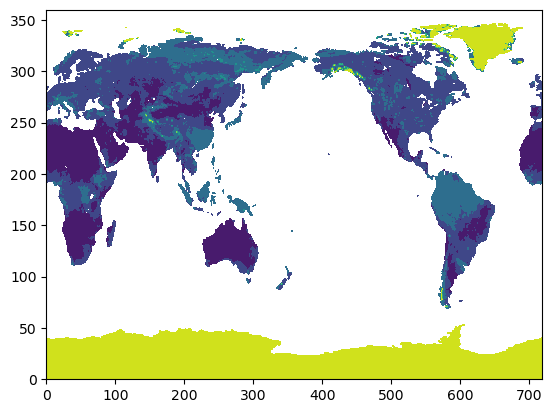

In [16]:
soilmvar = gfs.variables['Volumetric_Soil_Moisture_Content_depth_below_surface_layer']
# flip the data in latitude so North Hemisphere is up on the plot
soilm = soilmvar[0,0,::-1,:] 
print('shape=%s, type=%s, missing_value=%s' % \
      (soilm.shape, type(soilm), soilmvar.missing_value))
import matplotlib.pyplot as plt
%matplotlib inline
cs = plt.contourf(soilm)

##Packed integer data
There is a similar feature for variables with `scale_factor` and `add_offset` attributes.

- short integer data will automatically be returned as float data, with the scale and offset applied.  

## Dealing with dates and times
- time variables usually measure relative to a fixed date using a certain calendar, with units specified like ***`hours since YY:MM:DD hh-mm-ss`***.
- **`num2date`** and **`date2num`** convenience functions provided to convert between these numeric time coordinates and handy python datetime instances.  
- **`date2index`** finds the time index corresponding to a datetime instance.

In [17]:
from netCDF4 import num2date, date2num, date2index
timedim = sfctmp.dimensions[0] # time dim name
print('name of time dimension = %s' % timedim)
times = gfs.variables[timedim] # time coord var
print('units = %s, values = %s' % (times.units, times[:]))

name of time dimension = time1
units = Hour since 2023-05-25T12:00:00Z, values = [  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297. 300. 303. 306. 309. 312. 315. 318. 321. 324. 327. 330. 333.
 336. 339. 342. 345. 348. 351. 354. 357. 360. 363. 366. 369. 372. 375.
 378. 381. 384.]


In [18]:
dates = num2date(times[:], times.units)
print([date.strftime('%Y-%m-%d %H:%M:%S') for date in dates[:10]]) # print only first ten...

['2023-05-25 12:00:00', '2023-05-25 15:00:00', '2023-05-25 18:00:00', '2023-05-25 21:00:00', '2023-05-26 00:00:00', '2023-05-26 03:00:00', '2023-05-26 06:00:00', '2023-05-26 09:00:00', '2023-05-26 12:00:00', '2023-05-26 15:00:00']


###Get index associated with a specified date, extract forecast data for that date.

In [19]:
from datetime import datetime, timedelta
date = datetime.now() + timedelta(days=3)
print(date)
ntime = date2index(date,times,select='nearest')
print('index = %s, date = %s' % (ntime, dates[ntime]))

2023-05-28 15:57:27.760935
index = 25, date = 2023-05-28 15:00:00


###Get temp forecast for Boulder (near 40N, -105W)
- use function **`getcloses_ij`** we created before...

In [20]:
lats, lons = gfs.variables['lat'][:], gfs.variables['lon'][:]
# lats, lons are 1-d. Make them 2-d using numpy.meshgrid.
lons, lats = np.meshgrid(lons,lats)
j, i = getclosest_ij(lats,lons,40,-105)
fcst_temp = sfctmp[ntime,j,i]
print('Boulder forecast valid at %s UTC = %5.1f %s' % \
      (dates[ntime],fcst_temp,sfctmp.units))

Boulder forecast valid at 2023-05-28 15:00:00 UTC = 297.6 K


##Simple multi-file aggregation

What if you have a bunch of netcdf files, each with data for a different year, and you want to access all the data as if it were in one file?

In [21]:
!ls -ldgG data/prmsl*nc

-rw-rw-r-- 1 8985332 May 17 15:27 data/prmsl.2000.nc
-rw-rw-r-- 1 8968789 May 17 15:27 data/prmsl.2001.nc
-rw-rw-r-- 1 8972796 May 17 15:27 data/prmsl.2002.nc
-rw-rw-r-- 1 8974435 May 17 15:27 data/prmsl.2003.nc
-rw-rw-r-- 1 8997438 May 17 15:27 data/prmsl.2004.nc
-rw-rw-r-- 1 8976678 May 17 15:27 data/prmsl.2005.nc
-rw-rw-r-- 1 8969714 May 17 15:27 data/prmsl.2006.nc
-rw-rw-r-- 1 8974360 May 17 15:27 data/prmsl.2007.nc
-rw-rw-r-- 1 8994260 May 17 15:27 data/prmsl.2008.nc
-rw-rw-r-- 1 8974678 May 17 15:27 data/prmsl.2009.nc
-rw-rw-r-- 1 8970732 May 17 15:27 data/prmsl.2010.nc
-rw-rw-r-- 1 8976285 May 17 15:27 data/prmsl.2011.nc


**`MFDataset`** uses file globbing to patch together all the files into one big Dataset.
You can also pass it a list of specific files.

Limitations:

- It can only  aggregate the data along the leftmost dimension of each variable.
- only works with `NETCDF3`, or `NETCDF4_CLASSIC` formatted files.
- kind of slow.

In [22]:
mf = netCDF4.MFDataset('data/prmsl*nc')
times = mf.variables['time']
dates = num2date(times[:],times.units)
print('starting date = %s' % dates[0])
print('ending date = %s'% dates[-1])
prmsl = mf.variables['prmsl']
print('times shape = %s' % times.shape)
print('prmsl dimensions = %s, prmsl shape = %s' %\
     (prmsl.dimensions, prmsl.shape))

starting date = 2000-01-01 00:00:00
ending date = 2011-12-31 00:00:00
times shape = 4383
prmsl dimensions = ('time', 'lat', 'lon'), prmsl shape = (4383, 91, 180)


## Closing your netCDF file

It's good to close netCDF files, but not actually necessary when Dataset is open for read access only.


In [23]:
f.close()
gfs.close()

##That's it!

Now you're ready to start exploring your data interactively.

To be continued with **Writing netCDF data** ....